In [10]:
# ==========================================
# V1.1: LUNG CANCER DETECTION
# ==========================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# Globals vars
DATA_DIR = '../data/raw'
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
EPOCHS = 40

In [11]:
# EXPLORATION & ANALYSIS

# Class Distribution
class_names = sorted(os.listdir(DATA_DIR))  # [cancer 1, cancer 2, cancer 3]
total_images = 0
print(f"Number of Classes: {len(class_names)}")
print("Class Distribution:")

for name in class_names:
    path = os.path.join(DATA_DIR, name)
    count = len(os.listdir(path))
    total_images += count
    print(f" - {name}: {count} images")

print(f"Total Dataset Size: {total_images} images")

Number of Classes: 3
Class Distribution:
 - adenocarcinoma: 5000 images
 - benign: 5000 images
 - squamous_cell_carcinoma: 5000 images
Total Dataset Size: 15000 images


In [12]:
# Data loading and Augmentation...

print("\n--- [REQ] DATA AUGMENTATION SETUP ---")

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    validation_split=0.2, # 20% for testing, 80% for training!
    rotation_range=20,    # Data Augmentation, rotation between -20deg to 20deg
    zoom_range=0.2,       # Data Augmentation, random zoom from 80% to 120%
    horizontal_flip=True  # Data Augmentation, flipping a coin
)

# Training:
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # 128x128
    batch_size=BATCH_SIZE,   # 32 images simultaneously
    class_mode='categorical',  # Catergories of lung cancers
    subset='training',    # Telling this flow_from_directory() function that this is training
    shuffle=True          # Shuffle to prevent model cheating...
)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',   # Telling this flow_from_directory() function that this is for testing
    shuffle=False          # IMPORTANT: DO NOT SHUFFLE TO PREVENT MODEL CONFUSION!
)


--- [REQ] DATA AUGMENTATION SETUP ---
Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


Found 15000 images belonging to 3 classes.


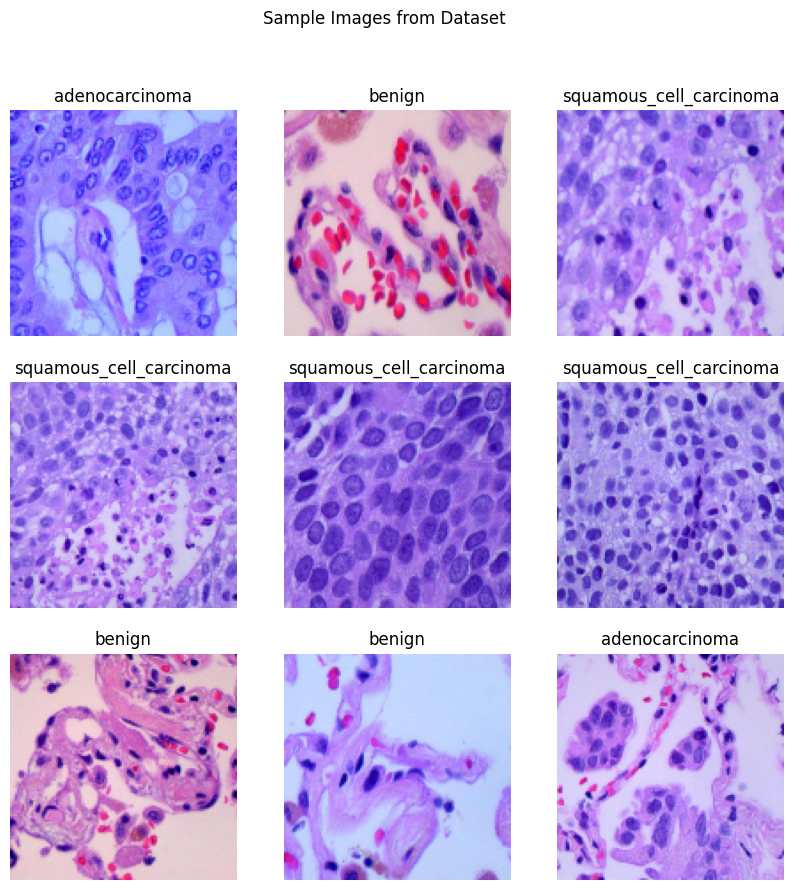

In [13]:
# Sample Images
temp_datagen = ImageDataGenerator(rescale=1./255)
temp_generator = temp_datagen.flow_from_directory(
    DATA_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=9, shuffle=True
)
images, labels = next(temp_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_index = np.argmax(labels[i])
    plt.title(list(temp_generator.class_indices.keys())[class_index])
    plt.axis("off")
plt.suptitle("Sample Images from Dataset")
plt.show()

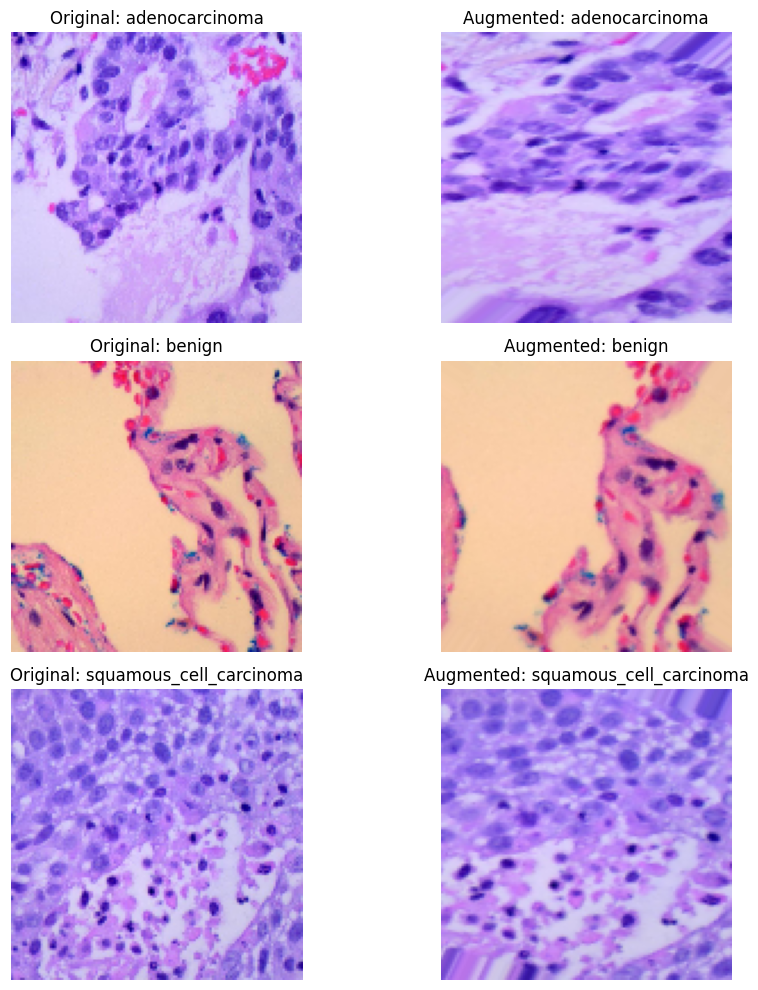

In [14]:
# Visualize Original images and augmented
from random import randint


classes = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)
    
plt.figure(figsize=(10, 10))
    
for i, class_name in enumerate(classes):
    class_folder = os.path.join(DATA_DIR, class_name)  # = ../data/raw + (/className)

    randomIndex = randint(0, len(os.listdir(class_folder)))
    random_image_file = os.listdir(class_folder)[randomIndex]
    img_path = os.path.join(class_folder, random_image_file)
        
    img = tf.keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))  # Load it using keras utils to snsure size 128x128
    img_array = tf.keras.utils.img_to_array(img) # Converts to shape (128, 128, 3)
        
    # Plot Original
    plt.subplot(3, 2, i*2 + 1)
    plt.imshow(img_array.astype('uint8'))  # Change to uint8 (0-255) because matplotlib hates float
    plt.title(f"Original: {class_name}")
    plt.axis('off')
        
    input_batch = img_array.reshape((1,) + img_array.shape)  # Shape: from (128, 128, 3) to (1, 128, 128, 3)
    aug_iter = aug_datagen.flow(input_batch, batch_size=1)
    aug_image = next(aug_iter)[0]
        
    # Plot augmented
    plt.subplot(3, 2, i*2 + 2)
    plt.imshow(aug_image) # This is already 0.0-1.0 (float), so it plots fine
    plt.title(f"Augmented: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [15]:
# MODEL DRAFT Initial CNN Architecture
# This cell is explained in README.md

model = Sequential([
    # Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    # Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax') # 3 Classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# TRAINING
from tensorflow.keras.callbacks import EarlyStopping
early_stop_condition = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stop_condition]
)
model.save('../models/draft_model.keras')

Epoch 1/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 173s 456ms/step - accuracy: 0.7983 - loss: 0.4531 - val_accuracy: 0.9077 - val_loss: 0.2695
Epoch 2/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 170s 452ms/step - accuracy: 0.8796 - loss: 0.3024 - val_accuracy: 0.9080 - val_loss: 0.2269
Epoch 3/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 173s 460ms/step - accuracy: 0.8974 - loss: 0.2578 - val_accuracy: 0.9253 - val_loss: 0.1943
Epoch 4/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 170s 453ms/step - accuracy: 0.9057 - loss: 0.2383 - val_accuracy: 0.9333 - val_loss: 0.1759
Epoch 5/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 169s 450ms/step - accuracy: 0.9181 - loss: 0.2086 - val_accuracy: 0.9173 - val_loss: 0.2132
Epoch 6/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 172s 458ms/step - accuracy: 0.9261 - loss: 0.1808 - val_accuracy: 0.9313 - val_loss: 0.1514
Epoch 7/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 169s 450ms/step - accuracy: 0.9314 - loss: 0.1763 - val_accuracy: 0.9440 - val_loss: 0.1465
Epoch 8/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 187s 498ms/step - accuracy: 0.9339 -

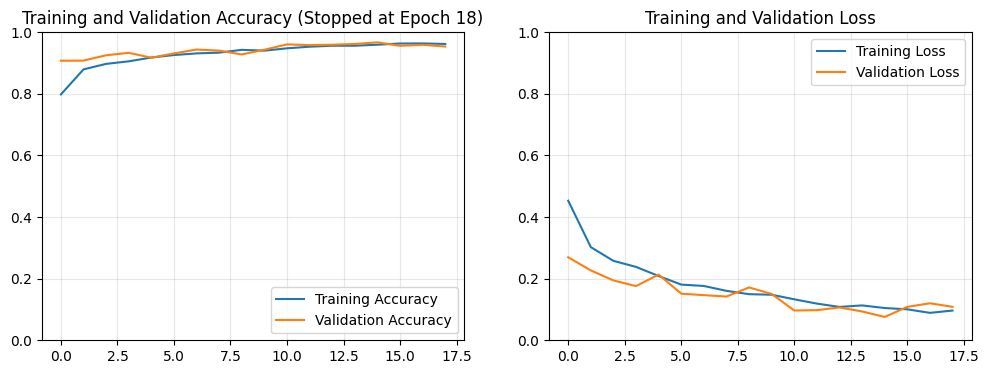

In [22]:
actual_epochs = len(history.history['accuracy'])
epochs_range = range(actual_epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy (Stopped at Epoch {actual_epochs})')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0, top=1.0)

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step
                         precision    recall  f1-score   support

         adenocarcinoma       0.94      0.96      0.95      1000
                 benign       1.00      1.00      1.00      1000
squamous_cell_carcinoma       0.97      0.94      0.95      1000

               accuracy                           0.97      3000
              macro avg       0.97      0.97      0.97      3000
           weighted avg       0.97      0.97      0.97      3000



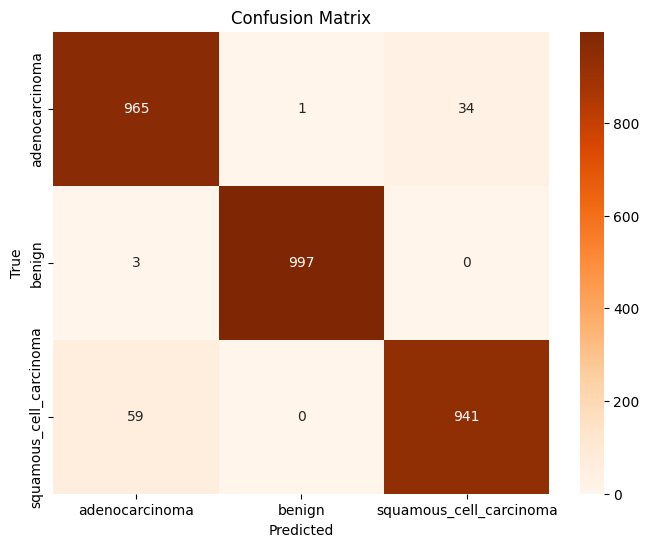

In [23]:
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# 1. Classification Report (Precision, Recall, F1)
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 2. Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()